In [1]:
# these are the Classes used from the Shapely library
# - https://shapely.readthedocs.io/en/stable/manual.html
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import LineString
from shapely.geometry import LinearRing

# these are the different cap styles for the "buffer" function
from shapely.geometry import CAP_STYLE, JOIN_STYLE

# plotting
import matplotlib.pyplot as plt

# arrays and math
import numpy as np

# image processing
import cv2

# opening files and paths
import os

In [2]:
# helper function to plot a Shapley Polygon object
def plot_poly(polygon):
    plt.plot(*polygon.exterior.xy)
    
    for i in polygon.interiors:
        plt.plot(*i.xy)

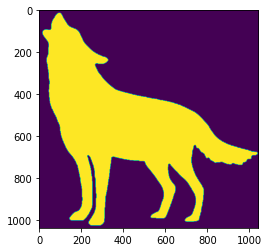

In [3]:
# initialization code - use this to change the image being processed

folder = "files" # this is the folder where the image files live

image = cv2.imread(os.path.join(folder,'wolf.png'),0)
plt.imshow(image)

image = image[::1,:]

filename = "wolf.gcode"

# TODO I might want to change this to work relative to the desired output size
# ~ right now it is relative to the image size, so smaller images need smaller numbers
line_dis = 10 # mm



In [4]:
# this returns all of the contours and heirarchy information
#  - returns a list of tuples --> (list of points, heirarchy)
def generate_border_lines(image):

    contours,heirarchy = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)  

    contour_list = []

    for contour,heirarchy in zip(contours, heirarchy[0]):
        point_list = []
        pt0 = None
        for point in contour:
            point_list.append(tuple(point[0]))
            
        contour_list.append((point_list, heirarchy))

    return contour_list

In [5]:
# get all of the children of the parent contour
# this is used to find the "holes" in the contour 
# the cv2.RETR_CCOMP property in "generate_border_lines" sets the children as the holes in the parent
def get_children(contour_list, parent_contour):

    child_list = []

    first_child_index = parent_contour[1][2]
    child = contour_list[first_child_index]
    child_list.append(child[0])


    # loop while there are more children
    while not child[1][0] == -1:
        next_child_index = child[1][0]
        child = contour_list[next_child_index]
        child_list.append(child[0])
    
    # return the list of children
    return child_list

In [6]:
# combine the contours into Shapely Polygons
# this uses the "get_children" function to find the holes in the Polygon
def create_contour_families(contour_list):

    family_list = []

    # find the first parent contour
    for contour in contour_list:
        
        # start with a parent contour
        if contour[1][3]==-1:

            # if there are no children, create an empty family with only the parent contour
            if contour[1][2] == -1:
                child_list = []
            # otherwise, find all of the children
            else:
                child_list = get_children(contour_list, contour)

            if len(contour[0]) > 2:
                family_list.append(Polygon(contour[0], holes=child_list))

    return family_list

In [7]:
# recursively run the distance transform on the input polygon
# - if result is empty, terminate with empty list
# - if result is Polygon, add current Polygon
# - if result is MultiPolygon, run for each Polygon in the MultiPolygon
def distance_transform(polygon, distance):
        
    t = polygon.buffer(distance, cap_style = CAP_STYLE.flat, join_style = JOIN_STYLE.mitre)
    
    # if t is empty, return the empty list
    if not t:
        return []
        
    result = []

    if t.type == "MultiPolygon":
        for p in t:
            result.append([p])
            result[-1].extend(distance_transform(p, distance))
    else:
        result.append(t)
        result.extend(distance_transform(t, distance))
        
        
    return result


In [8]:
# helper function to get the distance between two tuple points
def pt_dis(p1,p2):
    
    dx = p2[0]-p1[0]
    dy = p2[1]-p1[1]
    
    return np.sqrt(dx*dx+dy*dy)

In [9]:
# helper function to get the distance between two Shapely Point objects
def point_dis(p1,p2):
    
    dx = p2.x-p1.x
    dy = p2.y-p1.y
    
    return np.sqrt(dx*dx+dy*dy)

In [10]:
# create a simple spiral from the contour family object
# - this spirals inwards from the outside
def spiral_path_simple(contour_family, distance):
    
    points = []
        
    for contour in contour_family:
        
        contour_points = list(contour.exterior.coords)[0:-1]
              
        line = LineString([contour_points[-1], contour_points[0]])
        
        temp = Point([0,0])
        
        # TODO FIX THIS 
        index = 1
        
        while index <len(contour_points) and temp.length < distance:
            index += 1
            temp = LineString(contour_points[::-1][0:index])
        
        contour_points = contour_points[0:-index+1]

        points.extend(contour_points)

        ip = temp.interpolate(distance)

        points.append((ip.x, ip.y))
            
    return points

In [11]:
# rotate the polygon points so the start point is the minimum Y location
# - this is used to line-up the polygons for processing
# - TODO there is probably a better way to align the polygons...
def rotate_contours_ymin(contour):
    
    # find the minimum point in the contour, and set that to the start point
    points = list(contour.exterior.coords)[0:-1]

    index = 0
    min_y = points[0][1]

    for i, p in enumerate(points):

        if p[1] < min_y:
            index = i
            min_y = p[1]


    # rotate the points
    points = points[index:] + points[0:index]
    
    points.append(points[0])

    return points
    

In [12]:
# create a spiral path
# - 
def spiral_path_r(contour_family, distance):
    
    points = []
                
    for contour_points in contour_family:
        
        contour_points = rotate_contours_ymin(contour_points)
        
        temp = Point([0,0])
        
        # TODO FIX THIS 
        index = 1
        
        while index < len(contour_points) and temp.length < distance:
            index += 1
            temp = LineString(contour_points[::-1][0:index])
        
        contour_points = contour_points[0:-index+1]

        points.extend(contour_points)

        ip = temp.interpolate(distance)

        points.append((ip.x, ip.y))
            
    return points

In [13]:
# currently this is the best spiral algorithm, but it is not perfect
# - this finds the closest point to the next start point
# - if there is no next start point (center of spiral) it uses the distance input
def spiral_path_int(contour_family, distance):
    
    points = []
    
    # loop through each contour
    for i, contour_points in enumerate(contour_family):
        
        contour_points = rotate_contours_ymin(contour_points)
        
        # check if the next index is still in the contour family
        if i + 1 < len(contour_family):
            
            # get the next starting point
            next_start = Point(rotate_contours_ymin(contour_family[i+1])[0])

            loop = True
            
            # start the index at -2 to create a line string from the index to end (-1)
            # - LineString needs two points to be created
            index = -2
            
            while loop:
                
                # create the line string between the index and the end of the line
                lr = LineString(contour_points[index:][::-1])
                
                # find the closest point on the LineString
                temp_dis = lr.project(next_start)

                # move the index back one
                index -= 1
                
                # continue looping if the projection length is equal to the linestring length
                # - this implies the intersection point is on a line farther down the linestring
                loop = temp_dis == lr.length
        
        # if the next index does not exist, that means the transistion point has been reached
        # - this might be what is causing the issues in the center of the spirals
        # - I think changing "distance" to "distance/2" might help because the contour difference at the change is only one (going from odd to even)
        else:
            temp_dis = distance
              
        
        # remove the points that were skipped when finding the closest point
        # - I have a feeling this is over complicated
        temp = Point([0,0])
        index = 1
        while index < len(contour_points) and temp.length < temp_dis:
            index += 1
            temp = LineString(contour_points[::-1][0:index])
        
        contour_points = contour_points[0:-index+1]

        # add the contour points to the path
        points.extend(contour_points)
        
        # find the end point (using the distance from the projection calculation)
        ip = temp.interpolate(temp_dis)
        
        # add the end point to the path
        points.append((ip.x, ip.y))
    
            
    return points

In [14]:
# create the fermat spiral from combining two simple spirals (even and odd contours)
def spiral_path_fermat(contour_family, distance):
    
    points = []
    p1 = []
    p2 = []
    
    # distance is doubled because the gap between contours is 2
    distance = 2*distance

    # create the even spiral
    p1 = spiral_path_int(contour_family[::2], distance)
    
    # create the odd spiral
    p2 = spiral_path_int(contour_family[1:][::2], distance)
    
    # add the reverse of the second spiral to the first
    points = p1 + p2[::-1]

    # return the total path, and the even+odd paths for debugging
    # - when calling this function, just use "result,_,_" to omit the p1 and p2
    return points,p1,p2

In [15]:
# this is copied code from Shapely :)
# this cuts a LineString into two at a distance
# - this is used for the "combine_paths" function to combine the fermat paths
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

In [16]:
# returns a point past the end of the line
# - this is used for the "combine_paths" function
# - there is probably a better method for this
def extend_line(p1, p2, distance):
        
    dx = p2.x-p1.x
    dy = p2.y-p1.y
    
    angle = np.arctan2(dy,dx)

    px = p2.x+(np.cos(angle)*distance)
    py = p2.y+(np.sin(angle)*distance)
    
    return Point(px, py)

In [17]:
# this generates the total path without combining the paths
def generate_total_path(result, distance):
    
    total_path = []

    contour_family = []
    
    # loop through each value in the result
    for branch in result:

        if type(branch) is list:
            
            total_path.extend(generate_total_path(branch, distance))
        else:
            contour_family.append(branch)

    result,_,_ = spiral_path_fermat(contour_family, distance)

    total_path.append(result)

    return total_path

In [18]:
# this combines the root and branches path
def combine_paths(root, branches, dis):
        
    root_ls = LineString(root)
        
    # find the start and end points of the root
    for b in branches:
        
        s1 = Point(b[0])
        e1 = Point(b[-1])
        
        s2 = Point(b[1])
        e2 = Point(b[-2])
        
        
        # extend the endpoints out of the spiral
        s3 = extend_line(s2,s1,dis*1)
        e3 = extend_line(e2,e1,dis*1)
        
        
        # compute the end point connection
        ds1 = root_ls.project(s3)
        ds2 = root_ls.project(e3)        
        
        if ds1 == 0:  # cut the root at ds2

            # find the end point to add to the list
            end_point = root_ls.interpolate(ds2)
            ls1_list = []
            ls2_list = list(root_ls.coords)[1:] # drop the first point   
        elif ds2 == 0:  # cut the root at ds2

            # find the end point to add to the list
            end_point = root_ls.interpolate(ds2)
            ls1_list = list(root_ls.coords)
            ls2_list = []
        elif ds1 == root_ls.length:
            # cut the root at ds2
            ls1, ls2 = cut(root_ls, ds1-dis)    
            
            # find the end point to add to the list
            end_point = root_ls.interpolate(ds1)
            ls1_list = list(ls1.coords)
            ls2_list = list(ls2.coords)[1:] # drop the first point   
        
        # if the start is the first cut
        elif ds1 < ds2:
            
            # cut the root at the start point
            ls1, ls2 = cut(root_ls, ds1)
            
            # find the end point to add to the list
            end_point = root_ls.interpolate(ds2)
            ls1_list = list(ls1.coords)
            ls2_list = list(ls2.coords)[1:] # drop the first point   
        else:
            # cut the root at ds2
            ls1, ls2 = cut(root_ls, ds2)    
            
            # find the end point to add to the list
            end_point = root_ls.interpolate(ds1)
        
        
            ls1_list = list(ls1.coords)
            ls2_list = list(ls2.coords)[1:] # drop the first point        
        
        if ds1 < ds2:
            new_list = ls1_list + b + [end_point] + ls2_list
        else:
            new_list = ls1_list + b[::-1] + [end_point] + ls2_list        
        
        root_ls = LineString(new_list)
        
    return list(root_ls.coords)

In [19]:
# this creates a fermat path recursively from a tree of Polygon objects
def generate_fermat_path(result, distance):
    
    branches = []

    contour_family = []

    # loop through each node or branch in the tree
    for node in result:
        
        # if the result node is a branch, recursively call this function on it
        if type(node) is list:
            branches.append(generate_fermat_path(node, distance))
        # if the result node is not a branch, add it to the contour family
        else:
            contour_family.append(node)

    # generate the fermat spiral from the root and the branches
    root,_,_ = spiral_path_fermat(contour_family, distance)

    # combine the root and the branches
    if root:
        return combine_paths(root, branches, distance)
    
    # if there is no root (not sure how this happens but it does) - just return the branches?
    else:
        return branches


In [20]:
# execute runs the path function "fnc" on an image
# - use this to generate the path from an image
def execute(image, distance ,fnc):
    
    total_path = []
    
    # create the polygons from the image
    contours = generate_border_lines(image)
    polygons = create_contour_families(contours)
        
    # each individual polygon should be a separate distinct polygon in the image
    for polygon in polygons:
        
        # simplify the polygon to remove excess points - this helps with processing
        # - TODO there is likely a better value to use than "distance/2"
        polygon = polygon.simplify(distance/2)
        
        # generate the distance transform for the polygon
        result = distance_transform(polygon, -distance)
        
        # if there is a result, run the path generation function on the result
        if result:
            total_path.extend(fnc(result, distance))
    
    return total_path

In [21]:
# helper function to display the format of the "result" tree
# - the "result" tree is the representation of the distance transform 
# - EX: A tree of "['X','X','X', ['X',['X','X'], ['X']], ['X']]" has...
# 1. Three successive outer contours (no branches)
# 2. A branch with a single contour with a depth-2 branch and a depth-1 branch
# 3. A branch with a single contour

# TODO there is probably a better way to set up the trees in this scenario
def simplify_tree(result):
    
    root = []
    output = []
    for b in result:
        if type(b) is list:
            output.append(simplify_tree(b))
            
    return ["X"] + output

In [22]:
# plot a single path
def plot_path(path):
    
    X = []
    Y = []
    
    for p in path:
        X.append(p[0])
        Y.append(p[1])
        
    plt.plot(X,Y)

In [23]:
# recursively plot all paths in the total path
def plot_recursive_path(total_path):
    rest = []
    
    for path in total_path:
        
        if type(path) is list:
            plot_path(path)
        else:
            rest.append(path)
            
    plot_path(rest)

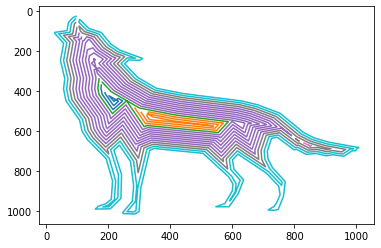

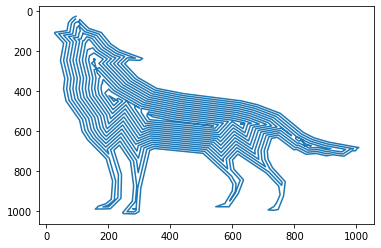

In [24]:
# Use this cell for testing - it generates the fermat spirals separate and combined and plots
# - you can use this to see the difference / errors with combinations
# path1 = create the separate path with fermat spirals
# path2 = create the combined path with fermat spirals

%matplotlib inline
path1 = execute(image, line_dis, generate_total_path)
path2 = execute(image, line_dis, generate_fermat_path)

plot_recursive_path(path1)
plt.gca().invert_yaxis()
plt.show()
plot_recursive_path(path2)
plt.gca().invert_yaxis()
plt.show()

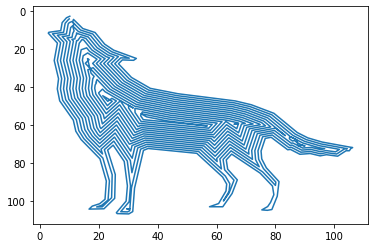

In [30]:
# this is some rough code to resize the image coordinates to mm size
# the input is in pixels
# I will need to add this as a function earlier in the process to get the line distance to work|
# - this scales evenly to fit the max size (one size will be within the bounds)

%matplotlib inline

max_x = 110
max_y = 160

scale_x = max_x / image.shape[1]
scale_y = max_y / image.shape[0]

if scale_x > scale_y:
    scale = scale_y
else:
    scale = scale_x

scale_path = []

for p in path2:
    scale_path.append((p[0]*scale, p[1]*scale))

plot_recursive_path(scale_path)
plt.gca().invert_yaxis()

In [26]:
# GCODE generation
# - this is used for converting the path into GCODE for the drawbot
# - applies an offset to each XY coordinate to avoid triggering the home flags repeatedly

x_offset = 2
y_offset = 2

# move the drawbot to a point
def command_move(p):
    return "G01 X" + str(p[0]+x_offset) + " Y" + str(p[1]+y_offset) + ";\n"

# move the pen up (drawbot specific)
def command_up():
    return "G01 Z0.5;\n"

# move the pen down (drawbot specific)
def command_down():
    return "G01 Z8.0;\n"

In [27]:
# GCODE generation
# - this takes the total path and creates a string of GCODE commands to follow the path
# - the expected input is a list of paths --> a single path should be in a list
def gcode(total_path, filename):
    
    # header function - home machine
    output = "G28 Z;\n"
    output += command_up()
    output += "G28 X Y;\n\n";
    
    for path in total_path:
        
        # move to p0
        output += command_move(path[0])
        
        # pen down
        output += command_down()
        
        # trace the path
        for p in path[1:]:
            output += command_move(p)
            
        # pen up
        output += command_up()
    
    # home machine
    output += "G28;\n"
    
    # print the number of commands
    print(len(output))
    
    # write the code to a gcode file
    f = open(filename, "w")
    f.write(output)
    f.close()
    
    # return the string (for debugging, not really needed)
    return output

In [28]:
def remove_short_paths(temp_path, length=20):
    
    clean_path = []
    
    for path in temp_path:
        
        if LineString(path).length > length:
            clean_path.append(path)
    
    return clean_path

In [29]:
_ = gcode([scale_path],filename)

23108
